In [1]:
from scipy.sparse import csr_matrix
from math import ceil, floor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
!wget -c "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv"

--2020-04-02 18:38:21--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.89.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.89.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1708674492 (1.6G) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-01.csv’

100%[====================================>] 1,708,674,492 69.9MB/s   in 25s    

2020-04-02 18:38:46 (65.2 MB/s) - ‘yellow_tripdata_2016-01.csv’ saved [1708674492/1708674492]



In [2]:
data = pd.read_csv("yellow_tripdata_2016-01.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RatecodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.5+ GB


In [3]:
data.drop([
    'VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 
    'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount'], 
    axis=1,
    inplace = True
)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   trip_distance          float64
 3   pickup_longitude       float64
 4   pickup_latitude        float64
 5   dropoff_longitude      float64
 6   dropoff_latitude       float64
 7   fare_amount            float64
dtypes: float64(6), object(2)
memory usage: 665.7+ MB


In [4]:
# filter the data by latitude, longitude
import json
manhattan_boundary = json.load(open('manhattan.geojson', 'r'))
coords = manhattan_boundary['features'][0]['geometry']['coordinates'][0]

min_lon = min([lon for lon, _ in coords])
max_lon = max([lon for lon, _ in coords])
min_lat = min([lat for _, lat in coords])
max_lat = max([lat for _, lat in coords])

data = data[(data["pickup_latitude"] >= min_lat) & (data["pickup_latitude"] <= max_lat) &
                (data["pickup_longitude"] >= min_lon) & (data["pickup_longitude"] <= max_lon) &
                (data["dropoff_latitude"] >= min_lat) & (data["dropoff_latitude"] <= max_lat) &
                (data["dropoff_longitude"] >= min_lon) & (data["dropoff_longitude"] <= max_lon)]

In [5]:
# filter data by fare_amount
print("99.9% of the fare amounts are less than: ", data["fare_amount"].quantile(q=0.999), "dollars")
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 100)]

99.9% of the fare amounts are less than:  52.0 dollars


In [6]:
# filter data by trip_distance
print("99.9% of the rip distances are less than: ", data["trip_distance"].quantile(q=0.999), "miles")
data = data[(data["trip_distance"] > 0) & (data["trip_distance"] < 24)]

99.9% of the rip distances are less than:  11.26 miles


In [7]:
data['tpep_pickup_datetime']= pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime']= pd.to_datetime(data['tpep_dropoff_datetime']) 

data["trip_duration"] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds()
print("99.9% of the trip duratins are less than: ", data["trip_duration"].quantile(q=0.999), "seconds")
data = data[(data["trip_duration"] > 0) & (data["trip_duration"] < 24*3600) ]

99.9% of the trip duratins are less than:  85546.0 seconds


In [8]:
data["speed"] = data["trip_distance"] / (data["trip_duration"] / 3600)
print("99.9% of the trip speeds are less than: ", data["speed"].quantile(q=0.999), "mph")
data = data[(data["speed"] > 0) & (data["speed"] < 100)]

99.9% of the trip speeds are less than:  37.84090909090909 mph


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9448808 entries, 5 to 10906853
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   trip_distance          float64       
 3   pickup_longitude       float64       
 4   pickup_latitude        float64       
 5   dropoff_longitude      float64       
 6   dropoff_latitude       float64       
 7   fare_amount            float64       
 8   trip_duration          float64       
 9   speed                  float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 793.0 MB


In [10]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R = 6371.0 * c # 6371 radius of the earth in km
    return km * 1000


In [11]:
grid_side_length = 300  # 300m
time_interval_length = 20  # 20 min

width = haversine_np(min_lon, min_lat, max_lon, min_lat)
height = haversine_np(min_lon, min_lat, min_lon, max_lat)

print(width, height)

H = ceil(height / grid_side_length)
W = ceil(width / grid_side_length)

print(H, W, H*W)

bottom_left_lon = np.array([min_lon] * data.shape[0])
bottom_left_lat = np.array([min_lat] * data.shape[0])
min_timestamp = pd.Timestamp('2016-01-01 00:00:00')


def set_grid_index(data):
  src_x = haversine_np(bottom_left_lon, bottom_left_lat, data["pickup_longitude"], bottom_left_lat)
  src_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["pickup_latitude"])

  src_x = np.floor(src_x / grid_side_length)
  src_y = np.floor(src_y / grid_side_length)
  data["pickup_grid"] = src_y * W + src_x

  dest_x = haversine_np(bottom_left_lon, bottom_left_lat, data["dropoff_longitude"], bottom_left_lat)
  dest_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["dropoff_latitude"])
  dest_x = np.floor(dest_x / grid_side_length)
  dest_y = np.floor(dest_y / grid_side_length)
  data["dropoff_grid"] = dest_y * W + dest_x


def set_timeinterval_index(data):
  time_delta_minutes = (data["tpep_pickup_datetime"] - min_timestamp).dt.total_seconds() / 60
  data["pickup_timeinterval_index"] = np.floor(time_delta_minutes / time_interval_length)

10303.529670673082 19914.53188192843
67 35 2345


In [12]:
set_grid_index(data)
set_timeinterval_index(data)
data = data.astype({'pickup_grid': 'int32', 'dropoff_grid': 'int32', 'pickup_timeinterval_index': 'int32'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9448808 entries, 5 to 10906853
Data columns (total 13 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   tpep_pickup_datetime       datetime64[ns]
 1   tpep_dropoff_datetime      datetime64[ns]
 2   trip_distance              float64       
 3   pickup_longitude           float64       
 4   pickup_latitude            float64       
 5   dropoff_longitude          float64       
 6   dropoff_latitude           float64       
 7   fare_amount                float64       
 8   trip_duration              float64       
 9   speed                      float64       
 10  pickup_grid                int32         
 11  dropoff_grid               int32         
 12  pickup_timeinterval_index  int32         
dtypes: datetime64[ns](2), float64(8), int32(3)
memory usage: 901.1 MB


In [13]:
data

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,trip_duration,speed,pickup_grid,dropoff_grid,pickup_timeinterval_index
5,2016-01-01 00:00:00,2016-01-01 00:18:30,5.52,-73.980118,40.743050,-73.913490,40.763142,19.0,1110.0,17.902703,573,836,0
6,2016-01-01 00:00:00,2016-01-01 00:26:45,7.45,-73.994057,40.719990,-73.966362,40.789871,26.0,1605.0,16.710280,254,1172,0
7,2016-01-01 00:00:01,2016-01-01 00:11:55,1.20,-73.979424,40.744614,-73.992035,40.753944,9.0,714.0,6.050420,573,709,0
8,2016-01-01 00:00:02,2016-01-01 00:11:14,6.00,-73.947151,40.791046,-73.920769,40.865578,18.0,672.0,32.142857,1177,2164,0
10,2016-01-01 00:00:03,2016-01-01 00:06:19,0.79,-74.006149,40.744919,-73.993797,40.741440,6.0,376.0,7.563830,565,534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10906848,2016-01-31 20:53:56,2016-01-31 21:05:13,2.84,-73.976212,40.786301,-73.977837,40.756989,11.5,677.0,15.101920,1134,748,2222
10906850,2016-01-31 22:36:41,2016-01-31 22:45:04,2.50,-74.009277,40.717049,-73.994637,40.750488,9.5,503.0,17.892644,215,639,2227
10906851,2016-01-31 22:53:00,2016-01-31 22:59:37,1.68,-74.003578,40.750751,-74.002159,40.734909,7.0,397.0,15.234257,636,462,2228
10906852,2016-01-31 23:00:11,2016-01-31 23:12:08,2.65,-74.002159,40.734852,-73.999680,40.761669,11.0,717.0,13.305439,462,777,2229


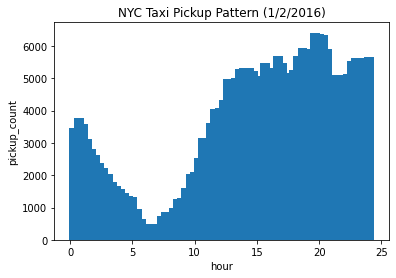

In [14]:
pickup_data = data.groupby('pickup_timeinterval_index').size().reset_index(name='pickup_count')
pickup_data['hour'] = pickup_data['pickup_timeinterval_index'] / 3

f = plt.figure()
plt.bar(
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['hour'] - 23,
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['pickup_count']
)
plt.xlabel('hour')
plt.ylabel('pickup_count')
plt.title('NYC Taxi Pickup Pattern (1/2/2016)')
f.savefig("pickups_by_hour.png", bbox_inches='tight', dpi=600)

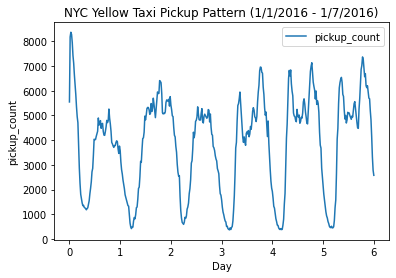

In [15]:
pickup_data['day'] = pickup_data['pickup_timeinterval_index'] / (3*24)
pl = pickup_data[pickup_data["day"] <= 6].plot(x='day', y='pickup_count')

plt.title("NYC Yellow Taxi Pickup Pattern (1/1/2016 - 1/7/2016)")
plt.ylabel('pickup_count')
plt.xlabel('Day')
# f.savefig("pickups_by_day.png", bbox_inches='tight', dpi=600)

fig = pl.get_figure()
fig.savefig('pickups_by_day.png')

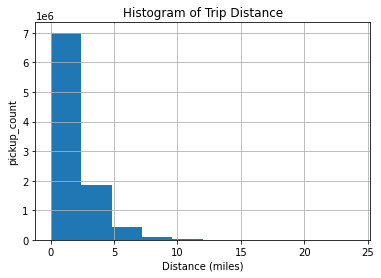

In [16]:
f = plt.figure()
distance_data = data['trip_distance'].hist()
plt.ylabel('pickup_count')
plt.xlabel('Distance (miles)')
plt.title('Histogram of Trip Distance')
f.savefig("trip_distance_histogram.png", bbox_inches='tight', dpi=600)

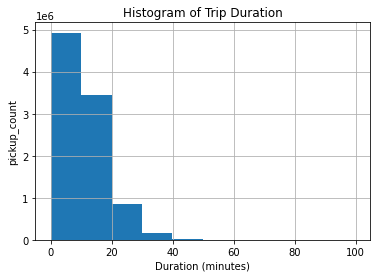

In [17]:
f = plt.figure()
duration_data = (data[data['trip_duration'] < 100*60]['trip_duration'] / 60).hist()
plt.ylabel('pickup_count')
plt.xlabel('Duration (minutes)')
plt.title('Histogram of Trip Duration')
f.savefig("trip_duration_histogram.png", bbox_inches='tight', dpi=600)

In [18]:
nets = {}
graph_data = data[["pickup_grid", "dropoff_grid", "pickup_timeinterval_index"]]

number_of_nodes = H*W
pickup_counts = np.zeros((number_of_nodes, max(graph_data["pickup_timeinterval_index"])))
dropoff_counts = np.zeros_like(pickup_counts)

for t in range (max(graph_data["pickup_timeinterval_index"])):
    t_graph_data = graph_data[graph_data["pickup_timeinterval_index"] == t]
    src, dest = t_graph_data['pickup_grid'], t_graph_data['dropoff_grid']
    pickups = t_graph_data.groupby('pickup_grid').size().to_dict()
    dropoffs = t_graph_data.groupby('dropoff_grid').size().to_dict()
    
    pickup_counts[list(pickups.keys()), t] = list(pickups.values())
    dropoff_counts[list(dropoffs.keys()), t] = list(dropoffs.values())
    
    nets[t] = {
        't': t,
        'mat': csr_matrix((np.ones(len(src), dtype=np.bool_), (src, dest)), shape=(H*W, H*W)),
    }

len(nets)

2231

In [19]:
from scipy import fftpack
sig_fft = fftpack.fft(pickup_counts)
sig_fft_real = 2 * np.abs(sig_fft / pickup_counts.shape[1])
sig_freqs = fftpack.fftfreq(pickup_counts.shape[1], 1 / (24 * 3))

sig_fft_real.shape, sig_freqs.shape

((2345, 2231), (2231,))

In [20]:
freq_mask = (sig_freqs > 0) & (sig_freqs < 3.1)  # Taking only positive frequencies, and time_period < 3 days
sig_freqs_masked = sig_freqs[freq_mask]

freq_mask = np.tile(freq_mask, (number_of_nodes, 1))
sig_fft_real_masked = sig_fft_real[freq_mask].reshape(number_of_nodes, -1)

sig_freqs_masked.shape, sig_fft_real_masked.shape

((96,), (2345, 96))

In [21]:
fourier_features = np.hstack((
    np.tile(sig_freqs_masked, (number_of_nodes, 1)),
    sig_fft_real_masked
))

fourier_features.shape
# fourier_frequencies = sig_freqs_masked  # same for all nodes
# fourier_amplitudes  = sig_fft_real_masked

(2345, 192)

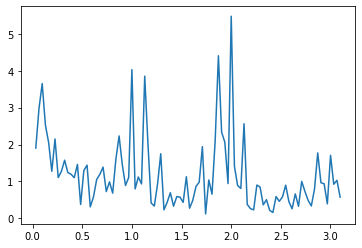

In [22]:
plt.plot(sig_freqs_masked, sig_fft_real_masked[573])

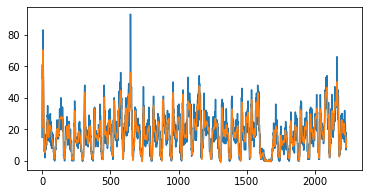

In [23]:
# visualize reconstruction quality from frequency domain
signal = pickup_counts[573]

sig_fft_reg = sig_fft[573].copy()
sig_fft_reg[np.abs(sig_freqs) > 7.1] = 0

sig_reg = np.real(fftpack.ifft(sig_fft_reg))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(signal)
ax.plot(sig_reg, '-')
# print(min(sig_reg))

In [24]:
def get_time_features(timeIntervalIndex, number_of_nodes):
    # hour of day, day of week: will be same for all nodes in the particular time interval
    time_interval_starting_timestamp = min_timestamp + timeIntervalIndex * pd.Timedelta('%s minutes' % time_interval_length)
    hour_of_day = time_interval_starting_timestamp.hour
    day_of_week = time_interval_starting_timestamp.dayofweek
    month_of_year = time_interval_starting_timestamp.month - 1
    
    # print(hour_of_day, day_of_week, month_of_year)
    
    hour = np.zeros((number_of_nodes, 24))
    hour[:, hour_of_day] = 1
    
    day = np.zeros((number_of_nodes, 7))
    day[:, day_of_week] = 1
    
    month = np.zeros((number_of_nodes, 12))
    month[:, month_of_year] = 1
    
    return np.hstack((hour, day, month))

In [25]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (7 entries)


In [26]:
'''
feature dimensions:
hour_of_day: possible values are 0-23, Dimension in one hot encoding = 24
day of week: possible values: 0-6, Dimension in one hot encoding = 7
month of year: possible values: 0-11, Dimension in one hot encoding = 12
pickup count history: Dimension 's'
weighted moving avergae of pickup count: Dimension 1
dropoff count history: 2 hours data, 2*3 = 6 timeinterval data, Dimesion 6
fourier frequencies: Dimension 96
fourier amplitudes: Dimension 96
Total Dimension: (24 + 7 + 12 + s + 1 + 6 + 96 * 2)
'''

s = 2
feature_dimension = 24 + 7 + 12 + s + 1 + 6 + fourier_features.shape[1]

max_timeinterval_index = max(graph_data["pickup_timeinterval_index"])
for t in range(max_timeinterval_index):
    # print('time interval index: %s/%s' % (t, max_timeinterval_index))
    X_time_features = get_time_features(t, number_of_nodes)
    # print(X_time_features.shape)
    
    # gather pickup historical values
    # handle previous timeinterval data not available case here
    # currently python is doing negative indexing
    historical_pickup_timeIntervalIndices = list(range(t - s * 7 * 24 * 3, t, 7 * 24 * 3))
    pickup_count_history = pickup_counts[:, historical_pickup_timeIntervalIndices]    
    # print(pickup_count_history.shape)
    
    # calculate weighted moving average of pickups
    weights = np.arange(1, s+1)
    weighted_moving_avg_pickup = np.dot(pickup_count_history, weights).reshape(-1, 1) / (s*(s+1)/2)
    # print(weighted_moving_avg_pickup.shape)
    
    # gather dropoff numbers in the previous day: 
    # go back one day, use sum of dropoff numbers starting at that time and or next 2 hours, i.e 2*3 = 6 time intervals
    historical_dropoff_timeIntervalIndices = list(range(t - 24 * 3, t - 24 * 3 + 6))
    dropoff_count_history = dropoff_counts[:, historical_dropoff_timeIntervalIndices]
    # print(dropoff_count_history.shape)
    
    # fourier frequencies
    # fourier_freqs = np.tile(fourier_frequencies, (number_of_nodes, 1))
    # print(fourier_freqs.shape)
    
    # fourier amplitudes
    # print(fourier_amplitudes.shape)
    
    nets[t]['X'] = np.hstack((
        X_time_features, pickup_count_history, weighted_moving_avg_pickup, dropoff_count_history, fourier_features
    ))
    
    # print(nets[t]['X'].shape)
    

In [27]:
nets[0]['X'].shape

(2345, 244)